In [13]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
## Reading GISS Data
def get_data():
  data_file = "/content/drive/MyDrive/GISS/station.csv"
  with open(data_file) as file:
        data = file.read()
  lines = data.split('\n')
  header = lines[0].split(',')
  lines = lines[1:]
  temperature = []
  for line in lines:
    linedata = line.split(',')
    linedata = linedata[1:13]
    for item in linedata:
      if item:
        temperature.append(float(item))
  series = np.array(temperature)
  time = np.arange(len(temperature), dtype='float32')
  return time, series

In [3]:
time, series = get_data()
mean = series.mean(axis=0)
series-=mean
std = series.std(axis=0)
series/=std

In [4]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(
      lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

## Spliting data

In [5]:
from posix import set_inheritable
from os import setregid
split_time =792
time_train = time[:split_time]
x_train = series[:split_time]
time_val = time[split_time:]
x_val = series[split_time:]

In [6]:
window_size = 24
batch_size = 12
shuffle_buffer_size = 48
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
valid_dataset = windowed_dataset(x_val, window_size, batch_size, shuffle_buffer_size)

In [18]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Bidirectional(
        tf.keras.layers.GRU(100,
                            return_sequences=True,
                            input_shape=[None, 1],
                            dropout=0.1,
                            recurrent_dropout=0.1)
    ),
    tf.keras.layers.GRU(100, dropout=0.1, recurrent_dropout=0.1),
    tf.keras.layers.Dense(1)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [20]:
model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=tf.keras.optimizers.SGD(learning_rate=1.5e-6, momentum=0.9),
    metrics=['mae']
)

In [21]:
history = model.fit(dataset, epochs=100, verbose=1, validation_data=valid_dataset)

Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 22s 191ms/step - loss: 0.0048 - mae: 0.0805 - val_loss: 0.7031 - val_mae: 0.8037
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 20s 229ms/step - loss: 0.0047 - mae: 0.0796 - val_loss: 0.7030 - val_mae: 0.8035
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 17s 166ms/step - loss: 0.0046 - mae: 0.0787 - val_loss: 0.7030 - val_mae: 0.8034
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 12s 182ms/step - loss: 0.0047 - mae: 0.0797 - val_loss: 0.7030 - val_mae: 0.8032
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 21s 183ms/step - loss: 0.0045 - mae: 0.0776 - val_loss: 0.7030 - val_mae: 0.8030
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 21s 185ms/step - loss: 0.0046 - mae: 0.0785 - val_loss: 0.7030 - val_mae: 0.8028
Epoch 7/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 20s 182ms/step - loss: 0.0045 - mae: 0.0780 - val_loss: 0.7030 - val_mae: 0.8026
Epoch 8/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 13s 205ms/step - loss: 0.0045 - mae: 0.0776 - val_loss: 0.7030 - val_mae: 0.8024
Epoch 9/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 2

In [22]:
predictions = model.predict(valid_dataset)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


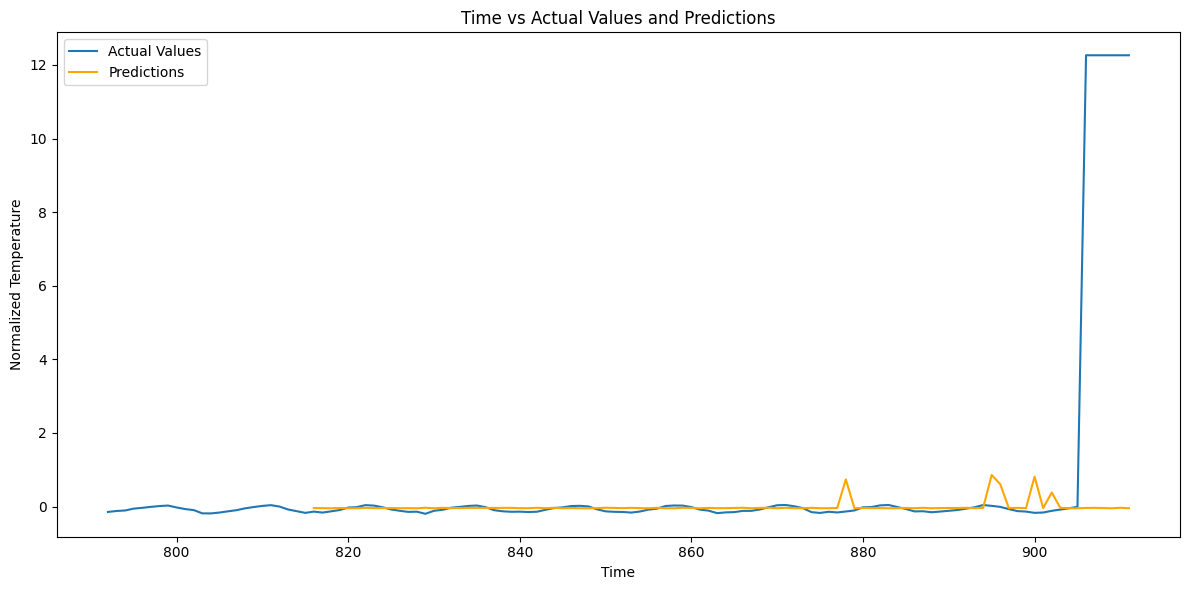

In [23]:
def plot_time_series(time_val, x_val, predictions):
    plt.figure(figsize=(12, 6))

    # Plot actual values vs predictions over time
    plt.plot(time_val, x_val, label='Actual Values')
    plt.plot(time_val[window_size:], predictions, label='Predictions', color='orange')

    plt.title("Time vs Actual Values and Predictions")
    plt.xlabel("Time")
    plt.ylabel("Normalized Temperature")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot actual vs predicted values over time
plot_time_series(time_val, x_val, predictions)